# **1) Import Libraries**

In [ ]:
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import plotly.graph_objects as go




# **2) Getting Data**

In [ ]:
import os
os.environ['KAGGLE_USERNAME']='gaydaazaid'
os.environ['KAGGLE_KEY']='ca62eb2b3fa33915e75565cc733b68c2'

In [ ]:
#download dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:13<00:00, 123MB/s]
100% 2.29G/2.29G [00:13<00:00, 188MB/s]


In [ ]:
#unzip file 
! unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# **3) Exploratory Data Analysis**

In [ ]:
chest_xray = '/content/chest_xray'
os.listdir(chest_xray)

['test', 'chest_xray', 'val', '__MACOSX', 'train']

In [ ]:
train_path = '/content/chest_xray/train'
valid_path = '/content/chest_xray/val'
test_path = '/content/chest_xray/test'

In [ ]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(chest_xray +'/'+ _set + '/NORMAL'))
    n_infect = len(os.listdir(chest_xray +'/'+ _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


Let's look at the images :

In [ ]:
cnt_imgs = 16  # we take 8 images for each class
norm_path = train_path + '/NORMAL'
pneumonia_path = train_path + '/PNEUMONIA'
norm_imgs = os.listdir(norm_path)[:cnt_imgs]
pneumonia_imgs = os.listdir(pneumonia_path)[:cnt_imgs]

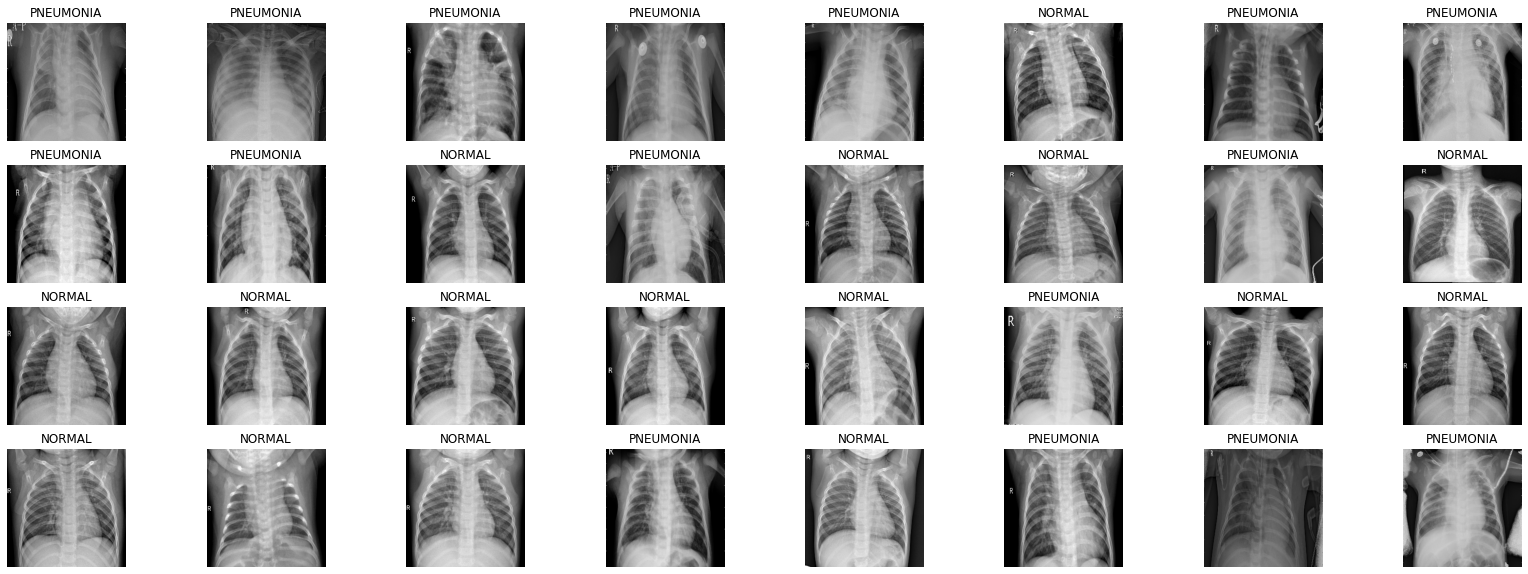

In [ ]:
IMAGE_SIZE = (256, 256)
counter = 0
norm_imgs_path = [norm_path + '/' + i for i in norm_imgs]
pneumonia_imgs_path = [pneumonia_path + '/' + j for j in pneumonia_imgs]
all_imgs = norm_imgs_path + pneumonia_imgs_path
random.shuffle(all_imgs)

plt.figure(figsize=(28, 10))
for img_path in all_imgs:
    plt.subplot(4, 8, counter + 1)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    label = img_path[len(train_path) + 1: img_path.rfind('/')]
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    counter += 1

In [ ]:
def check_cnt_label(label: str) -> int:
    """A function that should determine the number of objects of this
    class in the specified directories"""
    cnt_object = 0
    paths = [train_path, valid_path, test_path]
    for path in paths:
        path += '/' + label
        cnt_object += len(os.listdir(path))
    return cnt_object

CNT_NORMAL = check_cnt_label('NORMAL')
CNT_PNEUMONIA = check_cnt_label('PNEUMONIA')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['NORMAL', 'PNEUMONIA'],
    y=[CNT_NORMAL, CNT_PNEUMONIA],
    name='Primary Product',
    marker_color='indianred',
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

# **4) CNN Model Creating**

In [ ]:


def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
    directory=chest_xray+'/'+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=chest_xray+'/'+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(chest_xray +'/'+ 'test' + cond)):
            img = plt.imread(chest_xray+'/'+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
#Input Layer
inputs = Input(shape=(img_dims,img_dims,3))

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [ ]:
# Fitting the model
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

<ipython-input-17-0bb224dd53ba>:2: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
163/163 [==============================] - 91s 481ms/step - loss: 0.3481 - accuracy: 0.8409 - val_loss: 0.7437 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 75s 458ms/step - loss: 0.2571 - accuracy: 0.8967 - val_loss: 1.1292 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 76s 464ms/step - loss: 0.2189 - accuracy: 0.9158 - val_loss: 2.3533 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 74s 456ms/step - loss: 0.2077 - accuracy: 0.9212 - val_loss: 1.8940 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9304
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 74s 453ms/step - loss: 0.1920 - accuracy: 0.9304 - val_loss: 1.0987 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 6/10
163/163 [=============================

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

20/20 [==============================] - 1s 25ms/step
CONFUSION MATRIX ------------------
[[176  58]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 89.74358974358975%
Precision: 86.87782805429865%
Recall: 98.46153846153847%
F1-score: 92.3076923076923

TRAIN METRIC ----------------------
Train acc: 95.53
